# Objective
The objetive of this notebook is to replicate example of section 12.1 https://otexts.com/fpp3/complexseasonality.html.

# Description of the data
The number of calls to a North American commercial bank per 5-minute interval between 7:00am and 9:05pm each weekday over a 33 week period. There is a strong daily seasonal pattern with period 169 (there are 169 5-minute intervals per day), and a weak weekly seasonal pattern with period 169×5=845.
 

# Imports, configuration and constants

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import path
from sktime.forecasting.trend import STLForecaster
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [2]:
PLOT_TITLE = "Five-minute call volume to bank"
PLOT_YLABEL = "Calls"
PLOT_XLABEL = "DateTime[5m]"

# Load data

In [3]:
data_dir_path = "../data/"
bank_calls_path = path.join(data_dir_path, "bank_calls.rda")

result = pyreadr.read_r(bank_calls_path) # also works for Rds, rda

df = result['bank_calls']

df.columns = df.columns.str.lower()

# Functions

In [4]:
def fill_gaps_df(df: pd.DataFrame) -> pd.DataFrame:

    # Set the index to be the datetime column
    df = df.set_index('datetime')
    # Resample to 5-minute intervals, filling any missing values with NaN
    df = df.resample('5T').asfreq()
    
    df = df.reset_index()
    
    return df


def fill_gaps_ts(ts: pd.Series) -> pd.Series:

    # Resample to 5-minute intervals, filling any missing values with NaN
    ts = ts.resample('5T').asfreq()
    
    return ts


def plot_calls_df(df: pd.DataFrame, start_time: str=None, end_time: str=None):
    
    df = df.copy()
    
    if start_time is not None:
        df= df.query('datetime >= @start_time')
    if end_time is not None:
        df = df.query('datetime <= @end_time')
        
    x = df.datetime
    y = df.calls
    
    plt.plot(x, y)
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()
    
    
def plot_calls_ts(
    ts: pd.Series, 
    start_time: str = None, 
    end_time: str = None,
    lower_ci: pd.Series = None, 
    upper_ci: pd.Series = None
):
    
    if start_time is not None:
        ts = ts[ts.index >= start_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
        
    if end_time is not None:
        ts = ts[ts.index <= end_time]
        lower_ci = lower_ci[ts.index]
        upper_ci = upper_ci[ts.index]
    
    x = ts.index
    y = ts
    
    plt.plot(x, y)
    
    if lower_ci is not None and upper_ci is not None:
        plt.fill_between(x, lower_ci, upper_ci, alpha=0.2, label='Confidence Interval')
        plt.legend(loc='upper left')
    
    plt.xticks(rotation=70)
    plt.xlabel(PLOT_XLABEL)
    plt.ylabel(PLOT_YLABEL)
    plt.title(PLOT_TITLE)
    plt.show()

# Visualize data
There is daily (169 measures) and weekly seasonality (169*5 measures).

In [5]:
# Filling gaps with NaN so that those points are not interpolated in the plot
df_filled = fill_gaps_df(df)

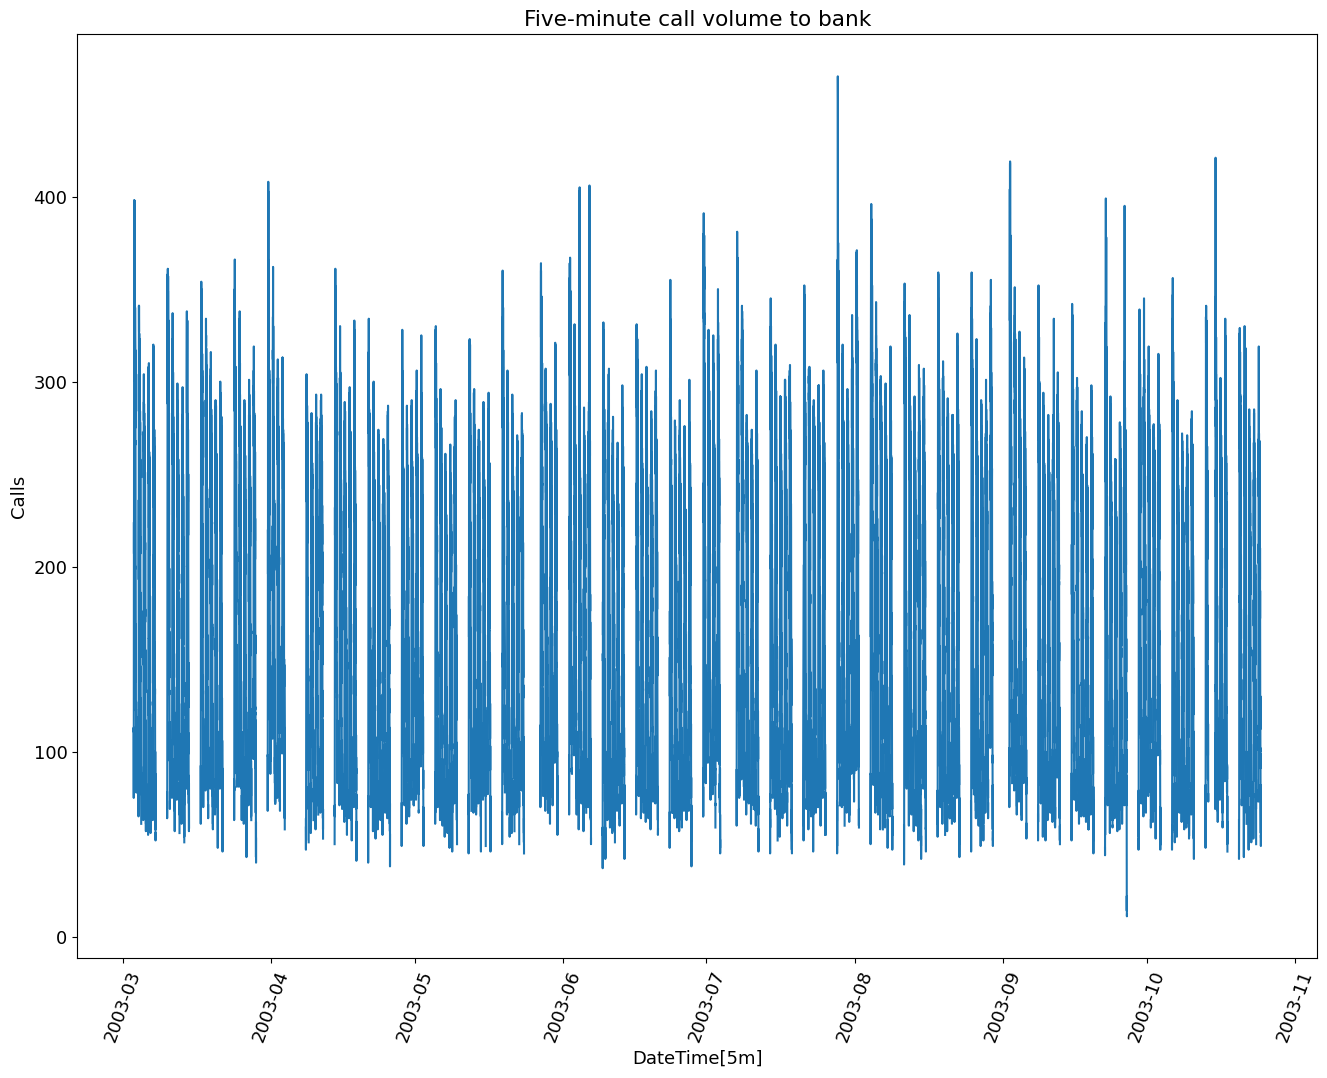

In [6]:
plot_calls_df(df_filled)

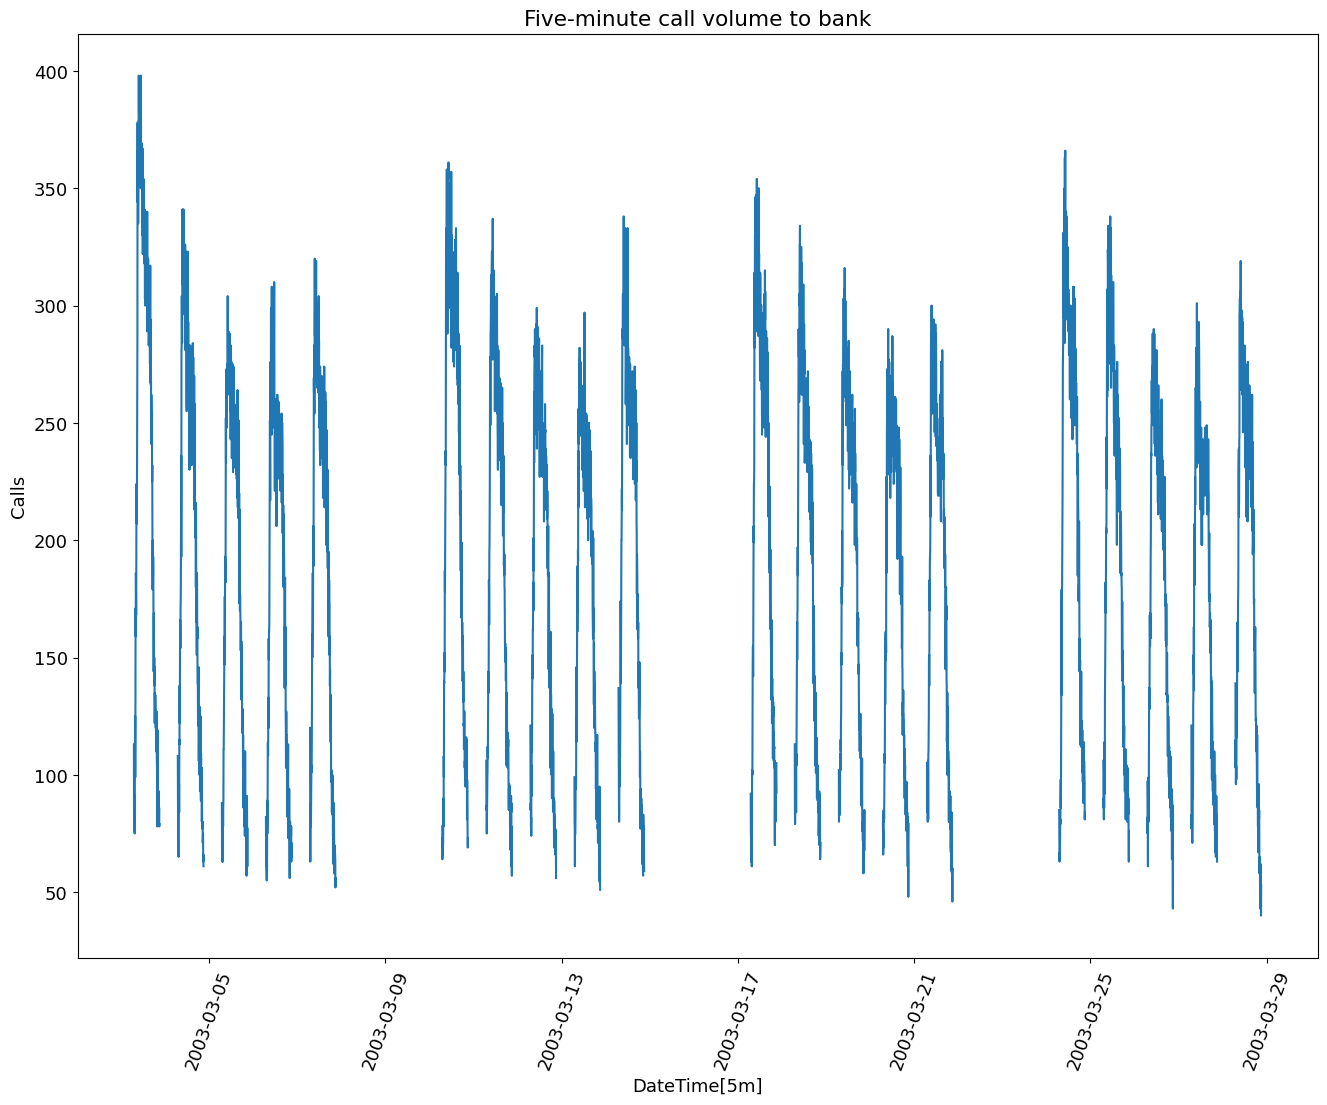

In [7]:
plot_calls_df(df_filled, start_time='2003-03-03 07:05:00', end_time='2003-03-28 21:15:00')

# Forecasting

We use sqrt transformation to ensure that forecasts remain positive. As seasonality is not proportional to the trend of the series, additive decompostion is appropriate. We are going to use STL to decompose both seasonal components of the series. Then, we will use ETS to forecast the adjusted time series and the seasonal components with seasonal naive method.

References:
- https://otexts.com/fpp3/forecasting-decomposition.html
- https://otexts.com/fpp3/components.html
- https://otexts.com/fpp3/complexseasonality.html

In [8]:
ts = pd.Series(df.calls.values, index=df.datetime)
ts.head()

datetime
2003-03-03 07:00:00    111.0
2003-03-03 07:05:00    113.0
2003-03-03 07:10:00     76.0
2003-03-03 07:15:00     82.0
2003-03-03 07:20:00     91.0
dtype: float64

In [9]:
ts.tail()

datetime
2003-10-24 20:40:00    64.0
2003-10-24 20:45:00    49.0
2003-10-24 20:50:00    54.0
2003-10-24 20:55:00    55.0
2003-10-24 21:00:00    54.0
dtype: float64

Lets reindex to avoid the missing values.

In [10]:
ts.index = range(len(ts.index))

In [11]:
sqrt_ts = np.sqrt(ts)

In [12]:
# Sktime does not have Season-Trend decomposition for multiple seasonalities. 
# Thus, I use statsmodels MSTL https://github.com/sktime/sktime/issues/2590

mstl = MSTL(sqrt_ts, periods=[169, 169*5])
res = mstl.fit()
res.seasonal.head()

,seasonal_169,seasonal_845
0,-4.029138,-0.419748
1,-4.694924,-0.018438
2,-5.933328,-0.083454
3,-5.756346,-0.290005
4,-5.450497,-0.003062


Our decompostion looks similar to the one of the book. However, results are not exact, this can be seen for example in the starting point of the trend component, the value range of the seasonal components or in the residual component. 

The book uses the following function https://rdrr.io/cran/feasts/man/STL.html. This function is based on `R. B. Cleveland, W. S. Cleveland, J.E. McRae, and I. Terpenning (1990) STL: A Seasonal-Trend Decomposition Procedure Based on Loess. Journal of Official Statistics, 6, 3–73.`

MSTL uses a more modern method `K. Bandura, R.J. Hyndman, and C. Bergmeir (2021) MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns. arXiv preprint arXiv:2107.13462.`. Our decomposition yields better results as it can be seen in the remainder component, which is smaller and looks more like white noise than the one from the book.

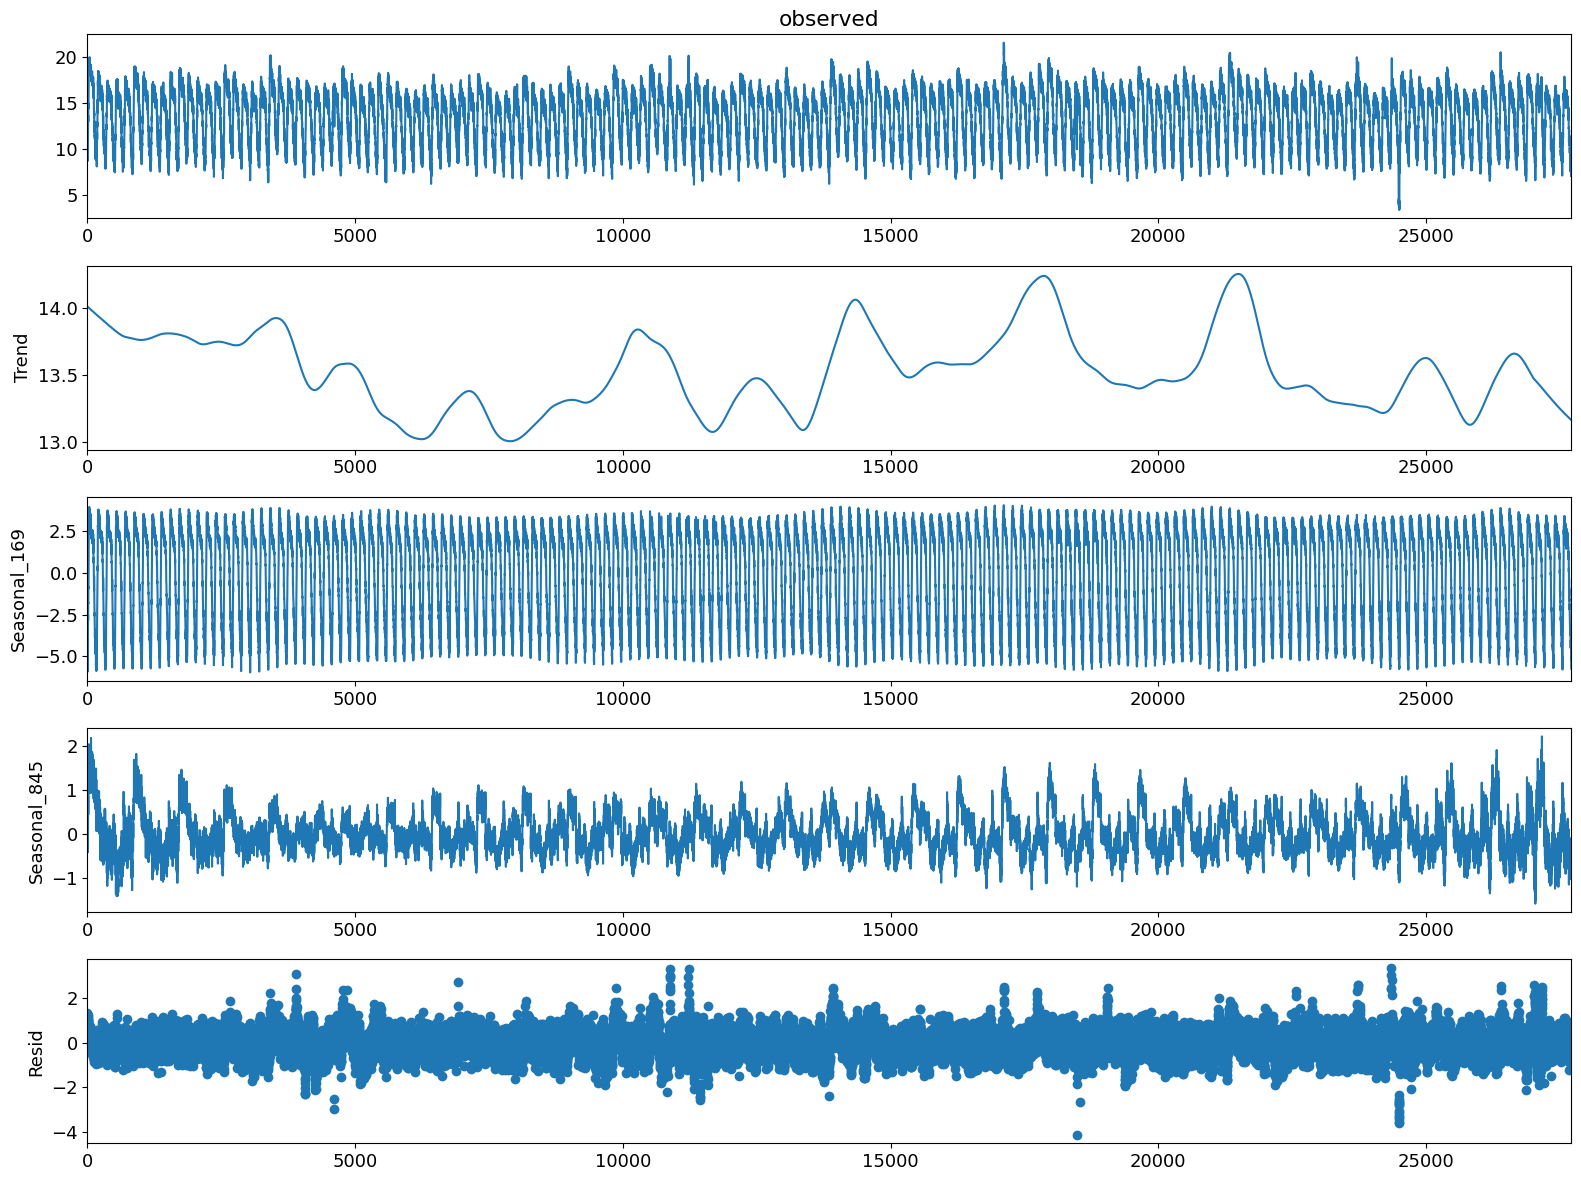

In [13]:
ax = res.plot()

In [14]:
# ts_a = res.trend
ts_a = res.trend + res.resid

In [15]:
ts_a

0        14.984539
1        15.343507
2        14.734580
3        15.101736
4        14.992951
           ...    
27711    13.219716
27712    12.791186
27713    13.012083
27714    12.850648
27715    13.458477
Length: 27716, dtype: float64

In [16]:
# plot_calls_ts(ts_a, start_time='2003-03-03 07:05', end_time='2003-03-28 21:15')

In [17]:
ets = ETSModel(ts_a)
fit = ets.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98075D-01    |proj g|=  3.33852D-01

At iterate    1    f=  5.90337D-01    |proj g|=  5.87512D-02

At iterate    2    f=  5.89730D-01    |proj g|=  3.06248D-02

At iterate    3    f=  5.89546D-01    |proj g|=  6.86781D-03

At iterate    4    f=  5.89538D-01    |proj g|=  6.36247D-04

At iterate    5    f=  5.89538D-01    |proj g|=  6.12510D-05

At iterate    6    f=  5.89538D-01    |proj g|=  7.75602D-05

At iterate    7    f=  5.89538D-01    |proj g|=  2.14817D-04

At iterate    8    f=  5.89538D-01    |proj g|=  5.52169D-04

At iterate    9    f=  5.89538D-01    |proj g|=  9.84657D-04

At iterate   10    f=  5.89537D-01    |proj g|=  1.56677D-03

At iterate   11    f=  5.89536D-01    |proj g|=  1.99495D-03

At iterate   12    f=  5.89536D-01    |proj g|=  1.71291D-03

At iterate   13    f=  5.8

<Axes: >

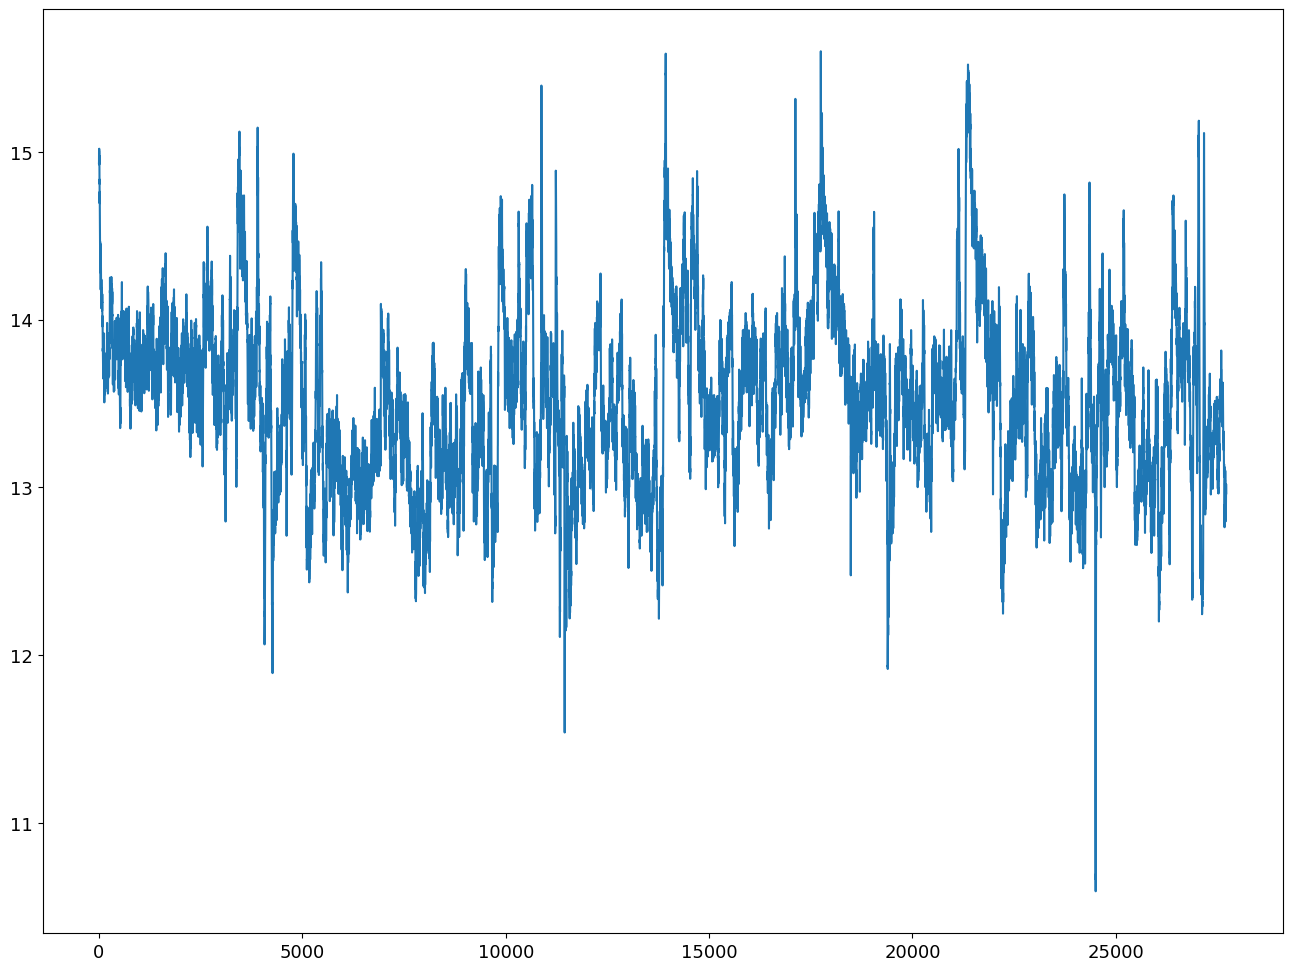

In [18]:
fit.fittedvalues.plot(label="statsmodels fit")

Forecasting the next week days for the seasonally adjusted component.

In [19]:
# TODO: change index to frecuency?
# pred = fit.get_prediction(start="2003-10-27 07:00:00", end="2003-10-31 21:00:00")
pred = fit.get_prediction(
    start=ts_a.index.max() + 1, 
    end=ts_a.index.max() + 169*5
)

In [20]:
df_pred = pred.summary_frame(alpha=0.05)

In [21]:
df_pred

,mean,pi_lower,pi_upper
27716,13.045622,12.190472,13.900773
27717,13.045622,12.179024,13.912221
27718,13.045622,12.167725,13.923519
27719,13.045622,12.156570,13.934674
27720,13.045622,12.145553,13.945691
...,...,...,...
28556,13.045622,8.887748,17.203497
28557,13.045622,8.885378,17.205867
28558,13.045622,8.883010,17.208235
28559,13.045622,8.880643,17.210602


In [22]:
ts_a_pred = pd.Series(
    df_pred['mean'].values, 
    index=df_pred.index,
)

ts_seasonal169 = pd.Series(
    res.seasonal['seasonal_169'].values, 
    index=res.seasonal['seasonal_169'].index,
)

ts_seasonal845 = pd.Series(
    res.seasonal['seasonal_845'].values, 
    index=res.seasonal['seasonal_845'].index,
)

In [23]:
res.seasonal['seasonal_845']

0       -0.419748
1       -0.018438
2       -0.083454
3       -0.290005
4       -0.003062
           ...   
27711   -0.607677
27712   -0.563772
27713   -0.563802
27714   -0.358359
27715   -0.356755
Name: seasonal_845, Length: 27716, dtype: float64

Manually creating the final forecasts. As we are forecasting with additive decomposition, we sum our just predict ETS values of the seasonally adjusted component to seasonally naive predictions of both seasonal components.

In [24]:
ts_h = np.power(
    ts_a_pred
    + pd.concat([ts_seasonal169.tail(169)]*5).values 
    + ts_seasonal845.tail(845).values,
    2
)

ts_h

27716    64.176628
27717    59.030761
27718    59.648508
27719    56.673080
27720    50.849392
           ...    
28556    61.244806
28557    52.626842
28558    54.494044
28559    57.929946
28560    48.102749
Length: 845, dtype: float64

Also, we manually create the lower and upper confidence intervals. As noted in https://otexts.com/fpp3/forecasting-decomposition.html these intervals are computed the following way:

    The prediction intervals shown in this graph are constructed in the same way as the point forecasts. That is, the upper and lower limits of the prediction intervals on the seasonally adjusted data are “reseasonalised” by adding in the forecasts of the seasonal component.

In [25]:
ts_pred_lower = pd.Series(
    df_pred['pi_lower'].values, 
    index=df_pred.index,
)

ts_pred_upper = pd.Series(
    df_pred['pi_upper'].values, 
    index=df_pred.index,
)

In [26]:
ts_h_lower = np.power(
    ts_pred_lower
    + pd.concat([ts_seasonal169.tail(169)]*5).values 
    + ts_seasonal845.tail(845).values,
    2
)

ts_h_upper = np.power(
    ts_pred_upper
    + pd.concat([ts_seasonal169.tail(169)]*5).values 
    + ts_seasonal845.tail(845).values,
    2
)

Reconstruing the index.

In [27]:
forecast_index = []

period = (
    pd.period_range(start="2003-10-27 07:00:00", end="2003-10-31 21:00:00", freq='5T')
    .to_timestamp()
)

for datetime in period:
    
    if datetime.hour >= 7 and datetime.hour < 21:
        forecast_index.append(datetime)
    elif datetime.hour == 21 and datetime.minute < 5:
        forecast_index.append(datetime)
        
ts_h.index = forecast_index
ts_h_lower.index = forecast_index
ts_h_upper.index = forecast_index

Visualizing the forecast (note we have not filled the gaps).

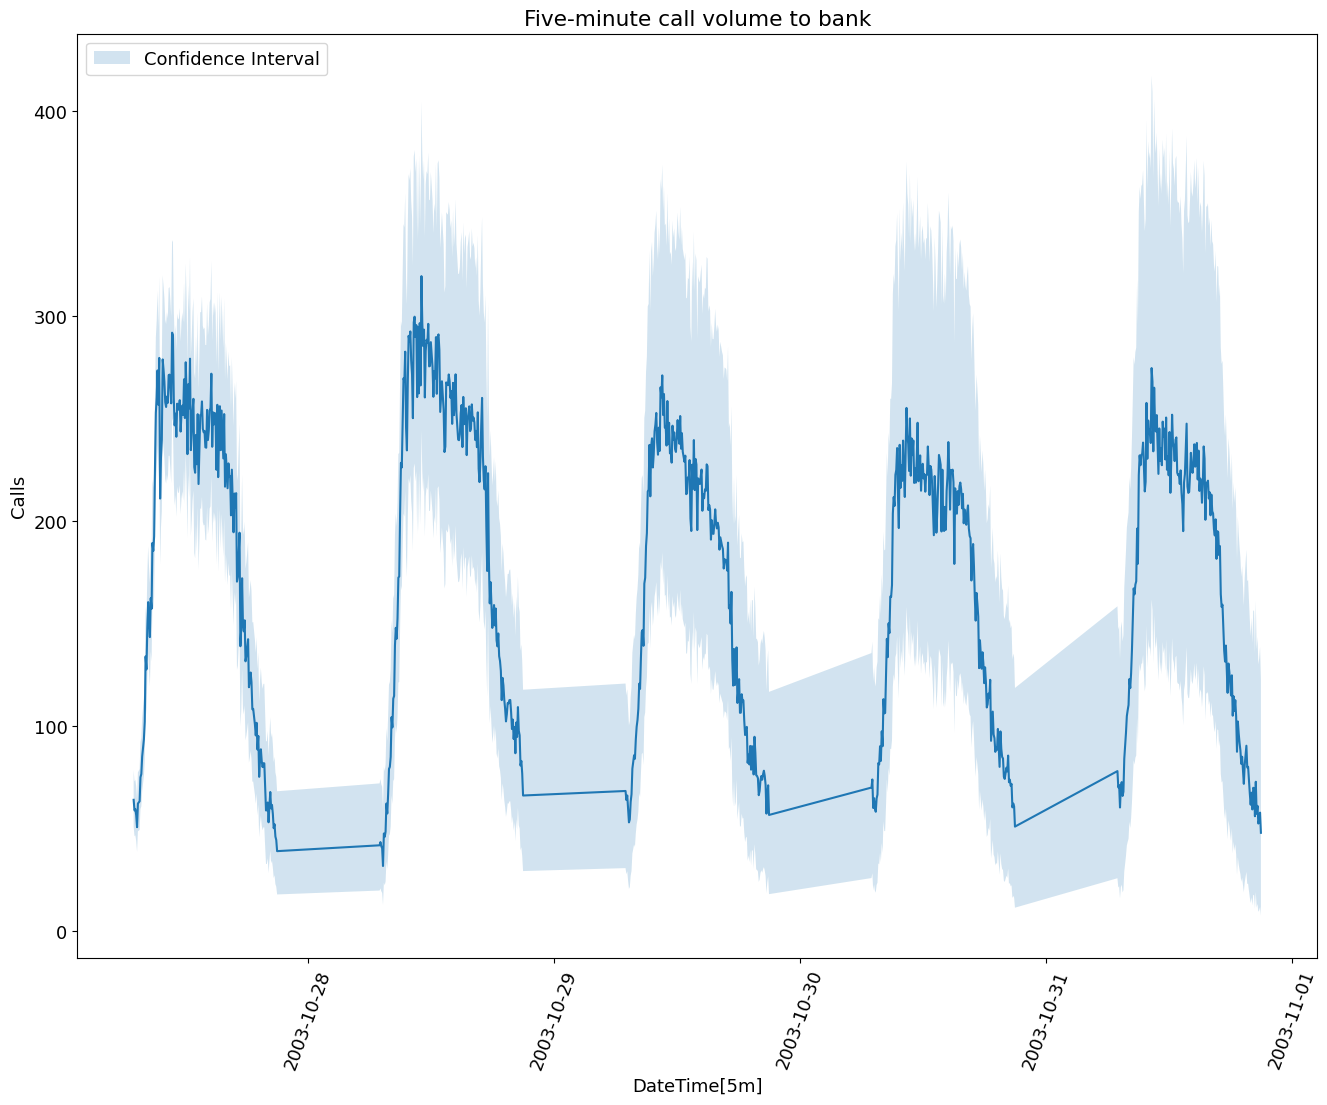

In [28]:
plot_calls_ts(ts_h, lower_ci=ts_h_lower, upper_ci=ts_h_upper)

Joining the point, upper and lower forecasts with the series.

In [29]:
ts_with_h = ts.copy()
# Recovering the series index
ts_with_h.index = df.datetime
ts_with_h = pd.concat([ts_with_h, ts_h])

ts_with_h_lower = ts_with_h.copy()
ts_with_h_lower[ts.index] = None
ts_with_h_lower[ts_h_lower.index] = ts_h_lower

ts_with_h_upper = ts_with_h.copy()
ts_with_h_upper[ts.index] = None
ts_with_h_upper[ts_h_upper.index] = ts_h_upper

Filling the gaps.

In [30]:
ts_with_h = fill_gaps_ts(ts_with_h)
ts_with_h_lower = fill_gaps_ts(ts_with_h_lower)
ts_with_h_upper = fill_gaps_ts(ts_with_h_upper)

Visualizing the three last weeks of the time series and the forecast of the following week.

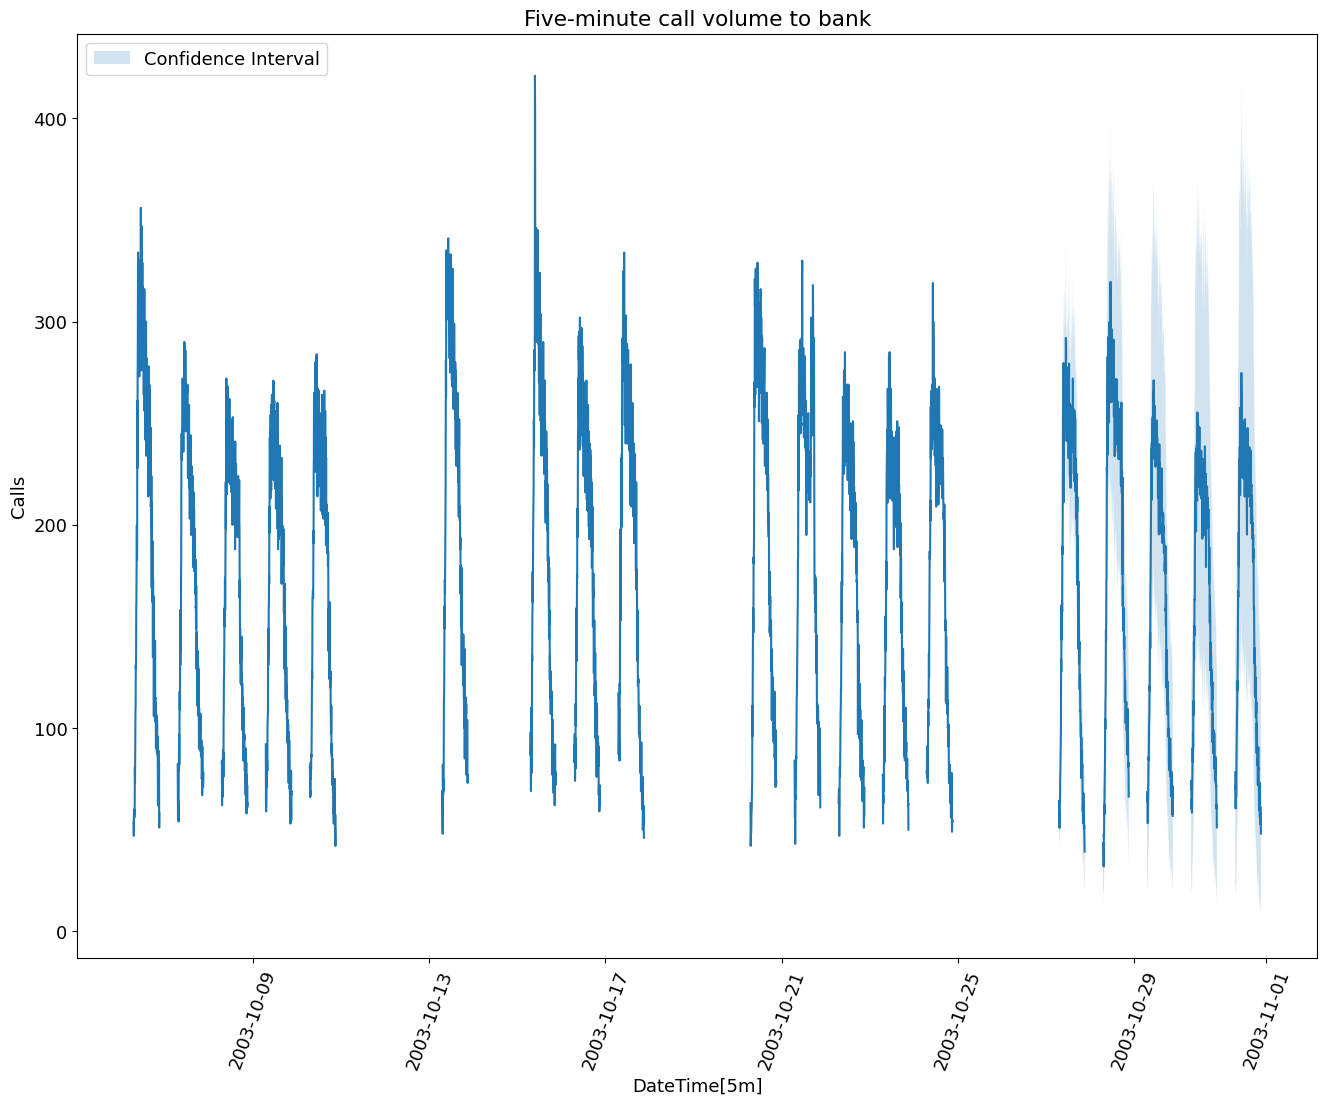

In [32]:
plot_calls_ts(
    ts_with_h, 
    start_time="2003-10-06 07:00:00", 
    end_time="2003-10-31 21:00:00", 
    lower_ci=ts_with_h_lower, 
    upper_ci=ts_with_h_upper
)